# EfficientNet-V2-M Hair Type Classifier (CORN Ordinal Regression)

Training on YOLO-filtered images with ordinal regression for hair type classification.

## Setup
1. **Enable GPU**: `Runtime` → `Change runtime type` → `GPU`
2. **Data expected at**: `MyDrive/hair_data/yolo_filtered_serpapi/`

## 1. Mount Drive & Check GPU

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU Available: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")
else:
    print("❌ No GPU! Go to Runtime → Change runtime type → GPU")
    raise RuntimeError("GPU required")

✅ GPU Available: Tesla T4
   Memory: 15.8 GB


## 2. Configuration

In [5]:
import os
import time
import shutil
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms, datasets
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm

# ============================================================
# CONFIGURATION
# ============================================================
DATA_DIR = "/content/drive/MyDrive/hair_data/yolo_filtered_serpapi/"  # Original YOLO images
OUTPUT_DIR = "/content/split/"
CHECKPOINT_DIR = "/content/drive/MyDrive/hair_data/checkpoints_corn/"  # New checkpoint dir

# Training parameters
IMG_SIZE = 512  # Resize all images to this
BATCH_SIZE = 8
ACCUMULATION_STEPS = 4  # Effective batch size = 32
EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 0.05  # Strong regularization

# Data split
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Resume?
RESUME_FROM_CHECKPOINT = True

# Create directories
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Verify data directory
if not os.path.exists(DATA_DIR):
    print(f"❌ Data directory not found: {DATA_DIR}")
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
else:
    classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    print(f"✅ Found {len(classes)} classes: {classes}")

    # Count images per class
    for cls in classes:
        cls_path = os.path.join(DATA_DIR, cls)
        n_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"   {cls}: {n_images} images")

✅ Found 10 classes: ['1', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c']
   1: 1860 images
   2a: 2166 images
   2b: 889 images
   2c: 699 images
   3a: 1611 images
   3b: 852 images
   3c: 1387 images
   4a: 1870 images
   4b: 2157 images
   4c: 2461 images


## 3. Ordinal Regression (CORN)

In [7]:
# Hair type ordering (1 → 4c is increasing curl)
CLASS_ORDER = {
    '1': 0, '2a': 1, '2b': 2, '2c': 3,
    '3a': 4, '3b': 5, '3c': 6,
    '4a': 7, '4b': 8, '4c': 9
}

class OrdinalClassifier(nn.Module):
    """Ordinal regression head using CORN method"""
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.fc = nn.Linear(in_features, num_classes - 1)

    def forward(self, x):
        return self.fc(x)


def corn_loss(logits, labels, num_classes):
    """CORN loss for ordinal regression"""
    losses = []
    for k in range(num_classes - 1):
        target = (labels > k).float()
        loss_k = F.binary_cross_entropy_with_logits(logits[:, k], target)
        losses.append(loss_k)
    return torch.stack(losses).mean()


def predict_from_ordinal(logits):
    """Convert ordinal logits to class predictions"""
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).sum(dim=1)
    return preds

print("✅ CORN ordinal regression defined")

✅ CORN ordinal regression defined


## 4. Split Dataset

In [8]:
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split images into train/val/test"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        os.makedirs(split_path)

    classes = sorted([d for d in os.listdir(source_dir)
                      if os.path.isdir(os.path.join(source_dir, d))])
    print(f"Found {len(classes)} classes: {classes}")

    stats = defaultdict(lambda: defaultdict(int))

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(cls_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(images) < 3:
            print(f"⚠️ Skipping '{cls}' - only {len(images)} images")
            continue

        train_imgs, temp_imgs = train_test_split(
            images, train_size=train_ratio, random_state=42, shuffle=True)
        relative_val = val_ratio / (val_ratio + test_ratio)
        val_imgs, test_imgs = train_test_split(
            temp_imgs, train_size=relative_val, random_state=42, shuffle=True)

        for split, img_list in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            split_cls_path = os.path.join(output_dir, split, cls)
            os.makedirs(split_cls_path, exist_ok=True)
            for img in img_list:
                shutil.copy2(os.path.join(cls_path, img), os.path.join(split_cls_path, img))
            stats[cls][split] = len(img_list)

    # Print stats
    print(f"\n{'='*50}")
    print(f"{'Class':<10} {'Train':<10} {'Val':<10} {'Test':<10}")
    print(f"{'-'*50}")
    total_train, total_val, total_test = 0, 0, 0
    for cls in classes:
        print(f"{cls:<10} {stats[cls]['train']:<10} {stats[cls]['val']:<10} {stats[cls]['test']:<10}")
        total_train += stats[cls]['train']
        total_val += stats[cls]['val']
        total_test += stats[cls]['test']
    print(f"{'-'*50}")
    print(f"{'TOTAL':<10} {total_train:<10} {total_val:<10} {total_test:<10}")

    return classes

In [9]:
print("=== Splitting Dataset ===")
CLASS_NAMES = split_dataset(DATA_DIR, OUTPUT_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
num_classes = len(CLASS_NAMES)

=== Splitting Dataset ===
Found 10 classes: ['1', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c']

Class      Train      Val        Test      
--------------------------------------------------
1          1302       279        279       
2a         1516       325        325       
2b         622        133        134       
2c         489        105        105       
3a         1127       242        242       
3b         596        128        128       
3c         970        208        209       
4a         1309       280        281       
4b         1509       324        324       
4c         1722       369        370       
--------------------------------------------------
TOTAL      11162      2393       2397      


## 5. Data Loaders (with Resizing)

In [10]:
# Training transforms - resize + augmentation
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize all images to standard size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Validation transforms - resize only
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize all images to standard size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "train"), train_tfms)
val_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "val"), val_tfms)
test_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, "test"), val_tfms)

print(f"\n✅ Datasets created (resizing to {IMG_SIZE}x{IMG_SIZE})")
print(f"   Train: {len(train_ds)} images")
print(f"   Val:   {len(val_ds)} images")
print(f"   Test:  {len(test_ds)} images")
print(f"   Classes: {train_ds.classes}")

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


✅ Datasets created (resizing to 512x512)
   Train: 11162 images
   Val:   2393 images
   Test:  2397 images
   Classes: ['1', '2a', '2b', '2c', '3a', '3b', '3c', '4a', '4b', '4c']


## 6. Model Setup

In [11]:
# Load pretrained EfficientNet-V2-M
print("Loading EfficientNet-V2-M...")
weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
model = efficientnet_v2_m(weights=weights)

# Get input features and replace classifier with ordinal head
in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),  # Strong dropout to prevent overfitting
    OrdinalClassifier(in_features, num_classes)
)
model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model ready with CORN ordinal regression")
print(f"   Parameters: {total_params:,}")
print(f"   Output: {num_classes - 1} thresholds for {num_classes} ordered classes")

Loading EfficientNet-V2-M...

✅ Model ready with CORN ordinal regression
   Parameters: 52,869,885
   Output: 9 thresholds for 10 ordered classes


## 7. Training Functions

In [12]:
def train_one_epoch(epoch):
    """Train one epoch with gradient accumulation"""
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} Training", leave=False)

    for i, (imgs, labels) in enumerate(pbar):
        imgs, labels = imgs.to(device), labels.to(device)

        with autocast('cuda'):
            logits = model(imgs)
            loss = corn_loss(logits, labels, num_classes) / ACCUMULATION_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f'{running_loss/(i+1):.4f}'})

    return running_loss / len(train_loader)


def validate(loader, desc="Validating"):
    """Validate with exact and within-1 accuracy"""
    model.eval()
    total, correct, correct_w1 = 0, 0, 0
    running_loss = 0
    all_preds, all_labels = [], []

    pbar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            with autocast('cuda'):
                logits = model(imgs)
                loss = corn_loss(logits, labels, num_classes)

            running_loss += loss.item()
            preds = predict_from_ordinal(logits)

            correct += (preds == labels).sum().item()
            correct_w1 += (torch.abs(preds - labels) <= 1).sum().item()
            total += len(labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'acc': f'{correct/total:.4f}', '±1': f'{correct_w1/total:.4f}'})

    accuracy = correct / total
    accuracy_w1 = correct_w1 / total
    avg_loss = running_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, accuracy_w1, f1, all_preds, all_labels

In [13]:
def save_checkpoint(epoch, model, optimizer, scaler, scheduler, best_val_acc, history):
    """Save checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history,
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth'))


def load_checkpoint(model, optimizer, scaler, scheduler):
    """Load checkpoint if exists"""
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pth')
    if os.path.exists(checkpoint_path) and RESUME_FROM_CHECKPOINT:
        print(f"Found checkpoint at {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scaler.load_state_dict(checkpoint['scaler_state_dict'])
            if 'scheduler_state_dict' in checkpoint:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_acc = checkpoint['best_val_acc']
            history = checkpoint['history']
            print(f"✅ Resumed from epoch {checkpoint['epoch']}")
            return start_epoch, best_val_acc, history
        except Exception as e:
            print(f"⚠️ Could not load checkpoint: {e}")

    print("Starting fresh training")
    return 1, 0.0, {
        'train_loss': [], 'val_loss': [],
        'val_acc': [], 'val_acc_within_1': [],
        'val_f1': [], 'lr': []
    }

## 8. Training Loop

In [14]:
# Setup
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler('cuda')
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Load checkpoint
start_epoch, best_val_acc, history = load_checkpoint(model, optimizer, scaler, scheduler)

# Early stopping
patience = 5
epochs_no_improve = 0

print(f"\n{'='*60}")
print("Training Configuration")
print(f"{'='*60}")
print(f"Model: EfficientNet-V2-M + CORN")
print(f"Data: YOLO-filtered images (resized to {IMG_SIZE}x{IMG_SIZE})")
print(f"Epochs: {start_epoch} to {EPOCHS}")
print(f"Batch: {BATCH_SIZE} (effective: {BATCH_SIZE * ACCUMULATION_STEPS})")
print(f"LR: {LR} (cosine annealing)")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Early stopping patience: {patience}")
print(f"{'='*60}\n")

Found checkpoint at /content/drive/MyDrive/hair_data/checkpoints_corn/latest_checkpoint.pth
✅ Resumed from epoch 8

Training Configuration
Model: EfficientNet-V2-M + CORN
Data: YOLO-filtered images (resized to 512x512)
Epochs: 9 to 20
Batch: 8 (effective: 32)
LR: 0.0003 (cosine annealing)
Weight decay: 0.05
Early stopping patience: 5



In [15]:
for epoch in range(start_epoch, EPOCHS + 1):
    start = time.time()
    current_lr = optimizer.param_groups[0]['lr']

    # Train & validate
    train_loss = train_one_epoch(epoch)
    val_loss, val_acc, val_acc_w1, val_f1, _, _ = validate(val_loader)

    scheduler.step()
    duration = time.time() - start

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_acc_within_1'].append(val_acc_w1)
    history['val_f1'].append(val_f1)
    history['lr'].append(current_lr)

    # Print summary
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Loss: {train_loss:.4f}/{val_loss:.4f} | "
          f"Acc: {val_acc:.4f} | "
          f"±1: {val_acc_w1:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"LR: {current_lr:.2e} | "
          f"{duration:.0f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model.pth"))
        print(f"  ✅ New best! (acc: {best_val_acc:.4f}, ±1: {val_acc_w1:.4f})")
    else:
        epochs_no_improve += 1
        print(f"  📉 No improvement ({epochs_no_improve}/{patience})")

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, scaler, scheduler, best_val_acc, history)

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"\n⏹️ Early stopping at epoch {epoch}")
        break

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*60}")

Epoch 09 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 09/20 | Loss: 0.1859/0.2356 | Acc: 0.4492 | ±1: 0.8354 | F1: 0.4489 | LR: 1.97e-04 | 656s
  📉 No improvement (1/5)


Epoch 10 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/20 | Loss: 0.1695/0.2464 | Acc: 0.4513 | ±1: 0.8320 | F1: 0.4489 | LR: 1.74e-04 | 656s
  ✅ New best! (acc: 0.4513, ±1: 0.8320)


Epoch 11 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11/20 | Loss: 0.1565/0.2563 | Acc: 0.4588 | ±1: 0.8391 | F1: 0.4562 | LR: 1.50e-04 | 661s
  ✅ New best! (acc: 0.4588, ±1: 0.8391)


Epoch 12 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12/20 | Loss: 0.1438/0.2676 | Acc: 0.4668 | ±1: 0.8274 | F1: 0.4654 | LR: 1.27e-04 | 666s
  ✅ New best! (acc: 0.4668, ±1: 0.8274)


Epoch 13 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13/20 | Loss: 0.1319/0.2758 | Acc: 0.4542 | ±1: 0.8316 | F1: 0.4553 | LR: 1.04e-04 | 656s
  📉 No improvement (1/5)


Epoch 14 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14/20 | Loss: 0.1199/0.2869 | Acc: 0.4517 | ±1: 0.8303 | F1: 0.4505 | LR: 8.26e-05 | 653s
  📉 No improvement (2/5)


Epoch 15 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15/20 | Loss: 0.1115/0.2954 | Acc: 0.4647 | ±1: 0.8320 | F1: 0.4669 | LR: 6.26e-05 | 657s
  📉 No improvement (3/5)


Epoch 16 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 16/20 | Loss: 0.1041/0.3007 | Acc: 0.4651 | ±1: 0.8237 | F1: 0.4691 | LR: 4.48e-05 | 651s
  📉 No improvement (4/5)


Epoch 17 Training:   0%|          | 0/1396 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validating:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 17/20 | Loss: 0.0981/0.3191 | Acc: 0.4639 | ±1: 0.8207 | F1: 0.4687 | LR: 2.96e-05 | 651s
  📉 No improvement (5/5)

⏹️ Early stopping at epoch 17

Training Complete!
Best validation accuracy: 0.4668


## 9. Evaluate on Test Set

In [16]:
# Load best model
best_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
if os.path.exists(best_path):
    model.load_state_dict(torch.load(best_path, weights_only=True))
    print(f"Loaded best model from {best_path}")

test_loss, test_acc, test_acc_w1, test_f1, test_preds, test_labels = validate(test_loader, "Testing")

print(f"\n{'='*40}")
print(f"TEST RESULTS")
print(f"{'='*40}")
print(f"Exact Accuracy:    {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"Within-1 Accuracy: {test_acc_w1:.4f} ({test_acc_w1*100:.1f}%)")
print(f"F1 Score:          {test_f1:.4f}")
print(f"{'='*40}")

Loaded best model from /content/drive/MyDrive/hair_data/checkpoints_corn/best_model.pth


Testing:   0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



TEST RESULTS
Exact Accuracy:    0.4552 (45.5%)
Within-1 Accuracy: 0.8056 (80.6%)
F1 Score:          0.4481


In [17]:
# Classification report
print("\n=== Classification Report ===")
print(classification_report(test_labels, test_preds, target_names=CLASS_NAMES))


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.79      0.74      0.76       279
          2a       0.52      0.65      0.58       325
          2b       0.26      0.22      0.24       134
          2c       0.19      0.10      0.13       105
          3a       0.68      0.56      0.61       242
          3b       0.21      0.20      0.20       128
          3c       0.42      0.43      0.42       209
          4a       0.31      0.19      0.24       281
          4b       0.32      0.48      0.39       324
          4c       0.46      0.47      0.47       370

    accuracy                           0.46      2397
   macro avg       0.42      0.40      0.40      2397
weighted avg       0.45      0.46      0.45      2397



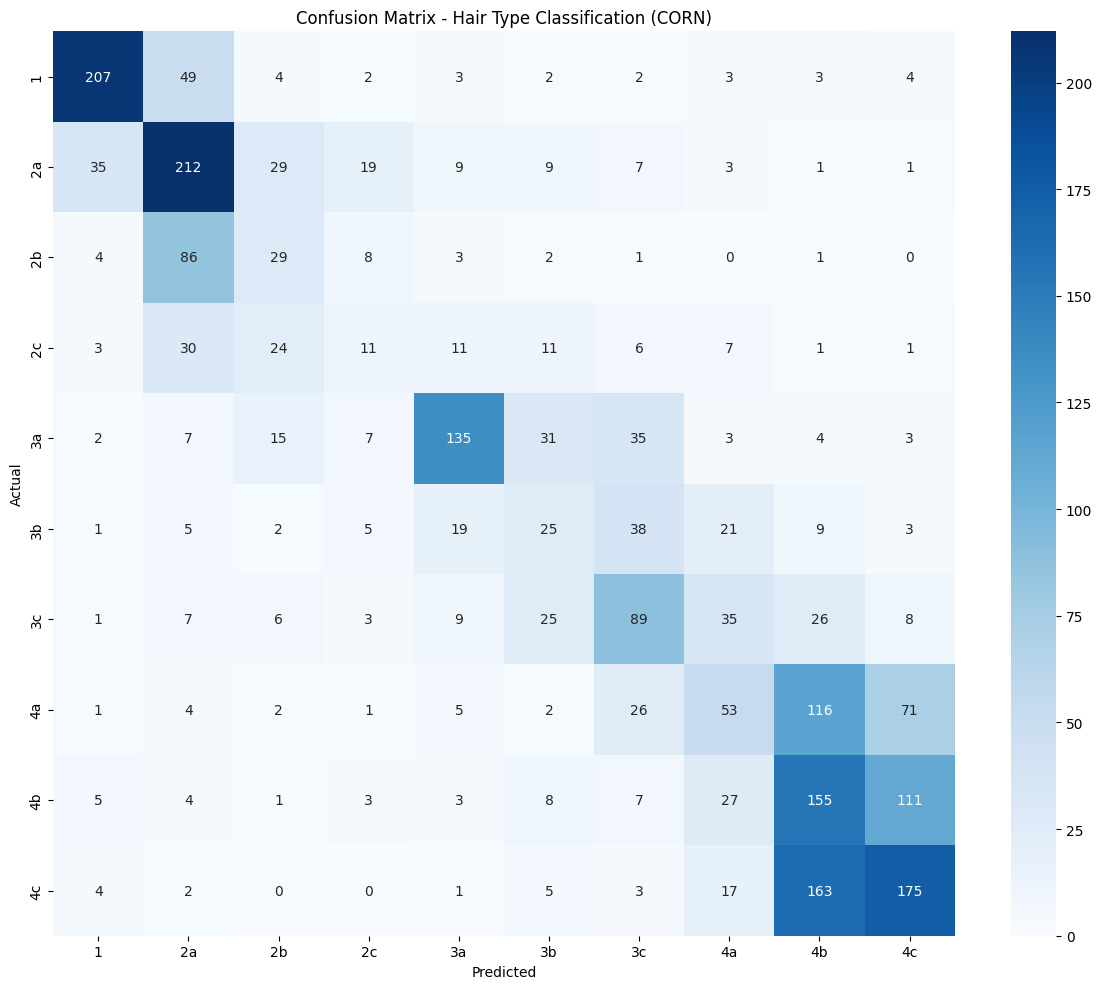

In [18]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Hair Type Classification (CORN)')
plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'confusion_matrix.png'), dpi=150)
plt.show()

## 10. Training History

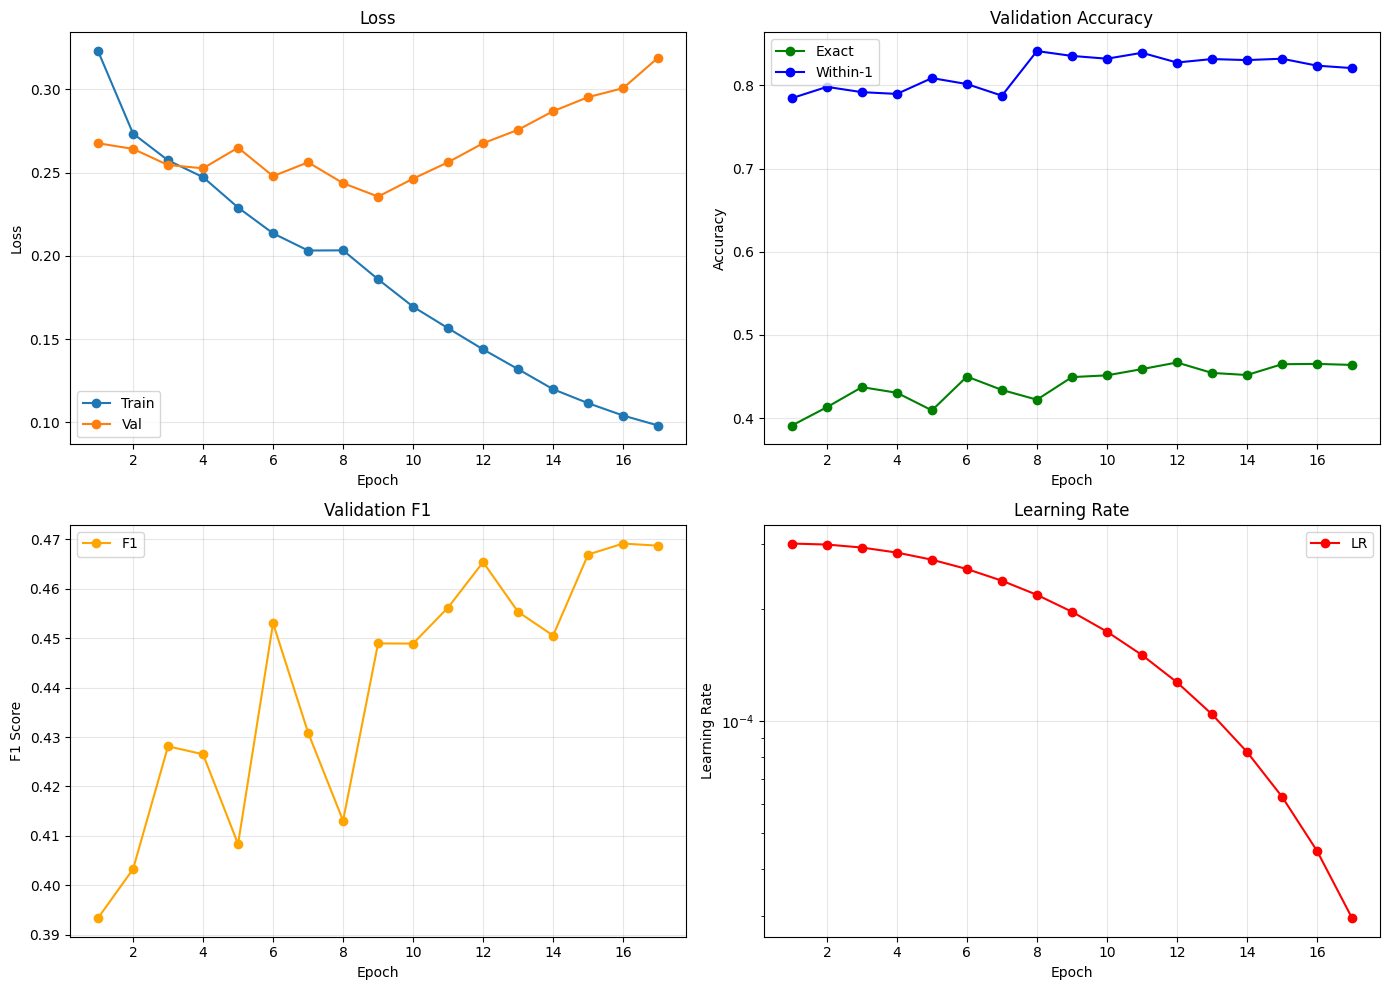

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(epochs_range, history['val_loss'], label='Val', marker='o')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, history['val_acc'], label='Exact', marker='o', color='green')
axes[0, 1].plot(epochs_range, history['val_acc_within_1'], label='Within-1', marker='o', color='blue')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1
axes[1, 0].plot(epochs_range, history['val_f1'], label='F1', marker='o', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# LR
axes[1, 1].plot(epochs_range, history['lr'], label='LR', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'training_history.png'), dpi=150)
plt.show()

## 11. Inference

In [20]:
from PIL import Image

def predict_hair_type(image_path, top_k=3):
    """Predict hair type with confidence scores"""
    model.eval()

    # Load and transform
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        pred = predict_from_ordinal(logits).item()
        probs = torch.sigmoid(logits)[0].cpu().numpy()

    pred_class = CLASS_NAMES[pred]

    # Get neighboring classes too
    neighbors = []
    for offset in [-1, 0, 1]:
        idx = pred + offset
        if 0 <= idx < len(CLASS_NAMES):
            neighbors.append(CLASS_NAMES[idx])

    return pred_class, neighbors

# Example:
# pred, neighbors = predict_hair_type("/path/to/image.jpg")
# print(f"Predicted: {pred}")
# print(f"Likely range: {neighbors}")